<a href="https://colab.research.google.com/github/thakerpragnesh/DeepLearning/blob/master/01_GPUConvNetSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Select the propeties of image data such as (ImageSize X ImageSize)  and Color Channel (3=RGB or 1=Grayscale)

In [ ]:
# import library to perform file operation
import os #use to access the files 
import tarfile # use to extract dataset from zip files
import sys

#import torch library to build neural network
import torch  # Elementory function of tensor is define in torch package
import torch.nn as nn # Several layer architectur is define here
import torch.nn.functional as F # loss function and activation function

# import torch library related to data processing
import torchvision # provides facilities to access image dataset
from torchvision.datasets.utils import download_url 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import cv2

In [ ]:
colorChannel = 3
ImageSize    = 64

#### Import Library to perform File operation


### Mount your google with secure authentication


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load dataset from the google drive

In [ ]:
PATH = '/content/gdrive/MyDrive/Dataset/DatasetArray/'
sys.path.append('/content/gdrive/MyDrive/Dataset/DatasetArray/')
training_data = np.load("/content/gdrive/MyDrive/Dataset/DatasetArray/IntelIC_3_64.npy", allow_pickle=True)

#### Normalise the input between 0 to 1 as normalize input tend to converge faster and gives better result

In [ ]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,colorChannel,ImageSize,ImageSize)
X = X/255.0
y = ([i[1] for i in training_data])
#y = np.argmax(y, axis=1) # Convert one hot representation to class index is data array is one hot vector

AxisError: ignored

#### Create Validation Dataset

In [ ]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

#### Spliting Data into validation data and training data and creating minibatches of selected sizes

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
train_X = X[:-val_size]
train_y = y[:-val_size]
train_X  = train_X.clone().detach()
train_y  = torch.tensor(train_y)

test_X = X[-val_size:]
test_y = y[-val_size:]
test_X  = test_X.clone().detach()
test_y  = torch.tensor(test_y)

train_ds = TensorDataset(train_X, train_y)
test_ds = TensorDataset(test_X, test_y)

batch_size =400
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, 2*batch_size, shuffle=False)

print("Number of element in Train Dataset:",len(train_X)) 
print("Numberof element in Test Dataset",len(test_X))

#### Now as our data is fully ready now build and train the model.

#### 1st import nn to define architecture

#### import nn.function to select activation function and loss function

#### Check if GPU is available and if yes run training on GPU

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#### Build the architecture of the Neural Network by selecting different kinds of layer

#### I am using all convolution layer of 3x3 filter with pading 1 i.e same conv

##### C1->C2->C3->P1->C4->C5->P2->C6->C7-C8(1X1)->FC1-OutLayer

#### C8 is 1x1 convolution layer that is used to reduce number of parameter

#### Defined evalOnTrain method ro test the model on Training dataset

#### Defined evalOnVal method ro test the model on Validation dataset


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.colorChannel = 3

        # 1st block to cover 7x7 preceptive field
        self.conv1 = nn.Conv2d(colorChannel, 32, kernel_size=3,stride=1,padding=1) 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3,stride=1,padding=1) 
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3,stride=1,padding=1)

        # 2nd block to cover 5x5 preceptive field
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=1)

        self.conv6 = nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=1)

        self.conv8 = nn.Conv2d(256, 512, kernel_size=3,stride=1,padding=1)

        self.dropout1 = nn.Dropout2d(0)
        self.dropout2 = nn.Dropout2d(0)
        x = torch.randn(colorChannel,ImageSize,ImageSize).view(-1,colorChannel,ImageSize,ImageSize)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 256) #flattening.
        self.fc2 = nn.Linear(256, 6) 

    def convs(self, x):
        # 1st block
        x = F.relu(self.conv1(x))
        x0 = x
        x = F.relu(self.conv2(x0)) 
        x = F.relu(self.conv3(x)+x0)
        x = F.max_pool2d(x,kernel_size=3,stride=2)

        # 2nd block
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x)+x)
        x = F.max_pool2d( x,kernel_size=3,stride=2)
        
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x,kernel_size=3,stride=2)

        x = F.relu( (self.conv7(x)))
        x = F.max_pool2d( x,kernel_size=3,stride=2)
        
        x = F.relu(self.conv8(x))
     
        x = self.dropout1(x)
        if self._to_linear is None:# below code must run only once
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)

        # view is reshape function of pytorch used as flatten function
        x = x.view(-1, self._to_linear)  
        x = F.relu(self.fc1(x))

        x = self.dropout2(x)

        # Special activation is required for output layer but as we are using
        # crossEntropy loss it internally calls softmax and thus no activation req
        x = self.fc2(x) 
        return x
        
    def evalute(self, Xset, yset):
      Xset.to(device)
      yset.to(device)
      correct = 0
      total = 0
      with torch.no_grad():
          for i in (range(len(Xset))):
              real_class =yset[i].to(device)
              net_out = net(Xset[i].view(-1, colorChannel, ImageSize, ImageSize).to(device))[0]  # returns a list, 
              predicted_class = torch.argmax(net_out)

              if predicted_class == real_class:
                  correct += 1
              total += 1
      return round(correct/total, 3)*100
    
    def computeBatchLoss(self,Xset,yset):
      with torch.no_grad():
        if torch.cuda.is_available():
          Xset.to(device)
          yset.to(device)
          Xset, yset = Xset.cuda(), yset.cuda() 
        #net.zero_grad()
        outputs = net(Xset)
        loss = 0
        loss = F.cross_entropy(outputs,yset)
        
      return loss


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


Move the model to device memory (i.e GPU Memory if GPU is available else does nothing)

In [ ]:
net = Net()
net.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0, inplace=False)
  (dropout2): Dropout2d(p=0, inplace=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

#### Choose appropraite optimization function and choose proper learning rate.

#### Most of the time ADAM oprimizer is best choice

In [ ]:
import torch.optim as optim
#import math
max_lr = 2e-2
optimizer = optim.Adam(net.parameters(), lr=max_lr, weight_decay=1e-3)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
trainHistory = []
trainLoss = []
testHistory = []
testLoss = []
lrHistory = []

In [ ]:
startEPOCHS = 0
count = 30
grad_clip = 0.2
stepCount = 0
print("Model training starts")
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=count,
                                            steps_per_epoch=(len(train_dl) )  )

for epoch in (range(startEPOCHS,(startEPOCHS + count))):
    batchLoss = []
    # We access the training data as a list of several minibatch stored in train_dl list
    for batch_X, batch_y in train_dl:
    #for batch_X,batch_y in enumerate(train_dl, 0):   
        # Move the batch of data to the device memory i.e GPU memory is present
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Pytorch accumulate the history of gradient and thus when we dont want to
        # accumulate previous history we must make it zero 
        net.zero_grad()
        outputs = net(batch_X)
        
        # Choose an apropraite loss function here we going to use cross entropy
        loss = F.cross_entropy(outputs,batch_y)
        batchLoss.append(loss)

        #loss = F.mse_loss(batch_y,outputs) 
        
        # below method performs back-propogation to compute gradient
        loss.backward()  
        
        # For few parameter value of gradient may be very high and overshoot the
        # optimal solution and so to avoid it we can define maximum allowed value 
        # for gradient and if gradient value is above it then it will bw clipped to max value
        if grad_clip: 
                nn.utils.clip_grad_value_(net.parameters(), grad_clip)

        optimizer.step()  # Does the update using selected optimizer

        lrHistory.append(get_lr(optimizer))
        sched.step()
    
    # uncomment below line if you want to save model in drive
    '''
    path = "/content/gdrive/My Drive/Colab Notebooks/TrainedModel/IntelIC" + str(epoch)
    torch.save(net,path)
    '''
    # Maintain the history of accuracy to see the growt of given model
    #trainHistory.append(net.evalute(train_X,train_y))
    epochLoss = sum(batchLoss) / len(batchLoss)
    trainLoss.append(epochLoss)


    testHistory.append(net.evalute(test_X,test_y))
    testLossList = []
    for batch_X, batch_y in test_dl:
      testLossList.append(net.computeBatchLoss(batch_X, batch_y))
    
    testLoss.append(sum(testLossList)/len(testLossList))
    #print(f"Training Accuracy : {trainHistory[-1]} Training Loss : {trainLoss[-1]}")
    #print(f"Testing Accuracy : {testHistory[-1]}  Testing loss : {testLoss[-1]}")
    print(f"Epoch: {epoch}. Training Loss: {epochLoss}")
    print(f"Epoch: {epoch}. Testing Loss: {testLoss[-1]}")
    print("******************************************************\n")

Model training starts


NameError: ignored

#### Check the training process and evalute trained model on training and validation dataset

#### Define a function to plot the accuracy stored in the list

In [ ]:
def plot_accuracies(history):
    plt.plot(history)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

###Plot training Accuracy

In [ ]:
#plot_accuracies(trainHistory)

###Ploat Validation Accuracy


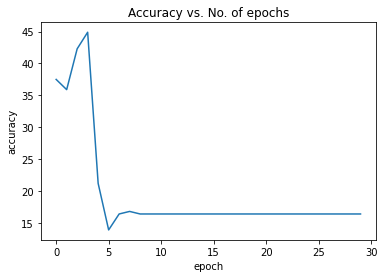

In [ ]:
plot_accuracies(testHistory)

Text(0, 0.5, 'LearningRate')

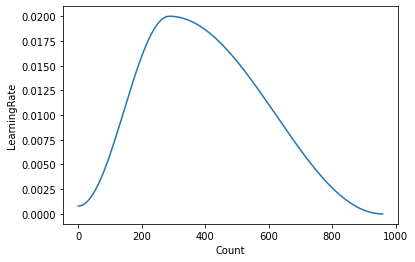

In [ ]:
plt.plot(lrHistory)
plt.xlabel('Count')
plt.ylabel('LearningRate')

#### If we want to rerun the training process and want to keep the history of all the training process run below cells

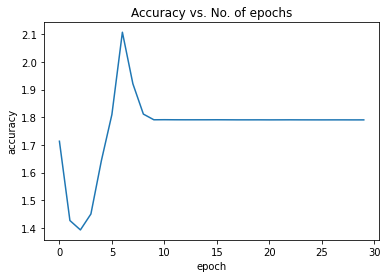

In [ ]:
plot_accuracies(trainLoss)

In [ ]:
#trainHistoryFull = []
#testHistoryFull = []

#### Comment above sell so we donot accidentally overright it with empty list

In [ ]:
for item in trainHistory:
  trainHistoryFull.append(item)

for item in testHistory:
  testHistoryFull.append(item)

NameError: ignored

In [ ]:
from matplotlib import pyplot as plt
plt.plot(testHistoryFull)

In [ ]:
#from matplotlib import pyplot as plt
#plt.plot(trainHistoryFull)

#### Plot and print train error and validation error together to check overfitting

In [ ]:
plt.plot(trainLoss)
plt.plot(testLoss)

In [ ]:
TrainAccuracy = net.evalute(train_X,train_y)
EvalAccuracy  = net.evalute(test_X,test_y)
print("\nTraining Error   :" + str(TrainAccuracy))
print("Validation Error :" +str(EvalAccuracy))

In [ ]:
path = "/content/gdrive/My Drive/Colab Notebooks/TrainedModel/IntelIC757"
torch.save(net, path)
#print(f"Train Error : {trainHistory[-1]}")
#print(f"Test Error : {testHistory[-1]}")

In [ ]:
PATH = "/content/gdrive/My Drive/Colab Notebooks/TrainedModel/IntelIC845"
model = torch.load(PATH)

In [ ]:
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)